In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import wall_growth_kit as walkit
import seaborn as sns
import math

%load_ext autoreload
%autoreload 2

The first part here implements the theory predictions for the strain-stiffening model. sum_3 and sum_4 are the better implementation, where we allow radius and $\lambda$ to vary as opposed to varying the number of layers in the wall.

In [2]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.15, 0.4
rad,n_cutoff=0.45,8  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'r0':rad,'n_cutoff':n_cutoff} 
# note we no longer define dt here.

In [3]:
def sum_1(temp_vals,temp_params):
    # Here, we calculate the LHS of the radial stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the turnover rate, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_r=temp_params['r0']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
#     temp_1=(temp_k*temp_dr/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    return temp_1


def sum_2(temp_vals,temp_params):
    # Here, we calculate the LHS of the longitudinal stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the cell wall layer number, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_p,temp_k=temp_params['P'],temp_params['K']
    temp_r=temp_params['r0']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_r*temp_a*((temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_n)+temp_nu*temp_dr*temp_n*(temp_n+1)/2 \
        +temp_dr*temp_a*(((temp_n+1)*temp_x**(temp_n+2)-(temp_n+2)*temp_x**(temp_n+1)+1)/(temp_x-1)**2-1-temp_n*(temp_n+1)/2) \
        +temp_nu*temp_dr**2*temp_n*(temp_n+1)*(2*temp_n+1)/(temp_r*6))
    return temp_1
    
    
def min_eq(temp_vals,temp_params):
    # We aim to find the roots of this equation in order to determine the possible growth and turnover rates
    # at steady state.
#     temp_num_layers=np.around(temp_vals[1]-1,0)  # number of layers needs to be an integer
    temp_sum_lim=temp_vals[1]-1  # number of layers - 1

    temp_vals1=list(temp_vals)+list([temp_params['n_cutoff'], temp_params['alpha1']])  # this is the innermost sum
    temp_vals2=list(temp_vals)+list([temp_sum_lim, temp_params['alpha2']])  # this is the outermost sum
    temp_vals3=list(temp_vals)+list([temp_params['n_cutoff'], temp_params['alpha2']])  # this is the difference sum 
#     print(temp_vals1, temp_vals2, temp_vals3)
    # defining terms here
    temp_dr=temp_params['dr']
    temp_p=temp_params['P']
    temp_r=temp_params['r0']
    temp_k=temp_params['K']
    # pressure rhs terms for radial and longitudinal constraints respectively
    temp_p1=(temp_r+temp_dr)*temp_p # radial constraint
    temp_p2=((temp_r+temp_dr)**2)*temp_p/(2)  # longitudinal constraint
    # Here we break the summations into their respective parts for the different alpha values. Note that this
    # is possible because the different layers sum linearly.
    temp1=sum_1(temp_vals1,temp_params)+sum_1(temp_vals2,temp_params)-sum_1(temp_vals3,temp_params)-temp_p1
    temp2=sum_2(temp_vals1,temp_params)+sum_2(temp_vals2,temp_params)-sum_2(temp_vals3,temp_params)-temp_p2
#     temp1=sum_1(temp_vals2,temp_params)-temp_p1
#     temp2=sum_2(temp_vals2,temp_params)-temp_p2
#     print(temp_p1, temp_p2)
    return [temp1,temp2]

So this is problematic. We can't let the number of layers be a non-integer, but if we don't do that, the system is unlikely to converge, and it feels like that is the best parameter that one can make dependent.

In [4]:
init=[2.65100419e-03, 20.0]
min_eq(init, params)

[-1.5662935219498046, -0.313221964865854]

In [5]:
init=[0.01,20.0]
sol = optimize.root(min_eq, init, args=(params),method='hybr')

In [6]:
sol.success

True

In [7]:
sol.x

array([0.06919464, 8.14958369])

In [8]:
min_eq(sol.x,params)

[-3.2451819009793326e-12, -5.668521207979893e-13]

Another option is to allow the radius to vary, with the layer number at which we see a change in stiffness dependent on the initial radius as $m=r_0*\epsilon^*/\Delta r$, where $\epsilon^*=0.02$.

This is the better theory implementation.

In [9]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

In [10]:
def sum_3(temp_vals,temp_params):
    # Here, we calculate the LHS of the radial stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
#     temp_1=(temp_k*temp_dr/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    return temp_1


def sum_4(temp_vals,temp_params):
    # Here, we calculate the LHS of the longitudinal stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_r*temp_a*((temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_n)+temp_nu*temp_dr*temp_n*(temp_n+1)/2 \
        +temp_dr*temp_a*(((temp_n+1)*temp_x**(temp_n+2)-(temp_n+2)*temp_x**(temp_n+1)+1)/(temp_x-1)**2-1-temp_n*(temp_n+1)/2) \
        +temp_nu*temp_dr**2*temp_n*(temp_n+1)*(2*temp_n+1)/(temp_r*6))
    return temp_1
    
    
def min_eq_v2(temp_vals,temp_params):
    # We aim to find the roots of this equation in order to determine the possible growth and radii
    # at steady state.
    temp_sum_lim=temp_params['N']-1  # number of layers - 1
    
    temp_r=temp_vals[1]
    temp_n_cutoff=np.floor(temp_params['strain_cutoff']*temp_r/temp_params['dr'])
    
    
    temp_vals1=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha1']])  # this is the innermost sum
    temp_vals2=list(temp_vals)+list([temp_sum_lim, temp_params['alpha2']])  # this is the outermost sum
    temp_vals3=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha2']])  # this is the difference sum 
#     print(temp_vals1, temp_vals2, temp_vals3)
    # defining terms here
    temp_dr=temp_params['dr']
    temp_p=temp_params['P']
    temp_k=temp_params['K']
    # pressure rhs terms for radial and longitudinal constraints respectively
    temp_p1=(temp_r+temp_dr)*temp_p # radial constraint
    temp_p2=((temp_r+temp_dr)**2)*temp_p/(2)  # longitudinal constraint
    # Here we break the summations into their respective parts for the different alpha values. Note that this
    # is possible because the different layers sum linearly.
    temp1=sum_3(temp_vals1,temp_params)+sum_3(temp_vals2,temp_params)-sum_3(temp_vals3,temp_params)-temp_p1
    temp2=sum_4(temp_vals1,temp_params)+sum_4(temp_vals2,temp_params)-sum_4(temp_vals3,temp_params)-temp_p2
#     temp1=sum_1(temp_vals2,temp_params)-temp_p1
#     temp2=sum_2(temp_vals2,temp_params)-temp_p2
#     print(temp_p1, temp_p2)
    return [temp1,temp2]

In [11]:
init=[0.01,0.42]
sol = optimize.root(min_eq_v2, init, args=(params),method='hybr')

In [12]:
sol.success

True

In [13]:
print('gr, radius', sol.x)
print('cutoff_layer', math.ceil(params['strain_cutoff']*sol.x[1]/params['dr']))

gr, radius [0.02238154 0.449365  ]
cutoff_layer 6


Okay, so this looks like it's doing a reasonable job, but it's having trouble converging within the fingertrap regime. We'll do two things. First, we'll confirm that this looks like our simulations are expected to.

This part implements simulations on the strain-stiffening model.

/Users/felixbarber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/felixbarber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


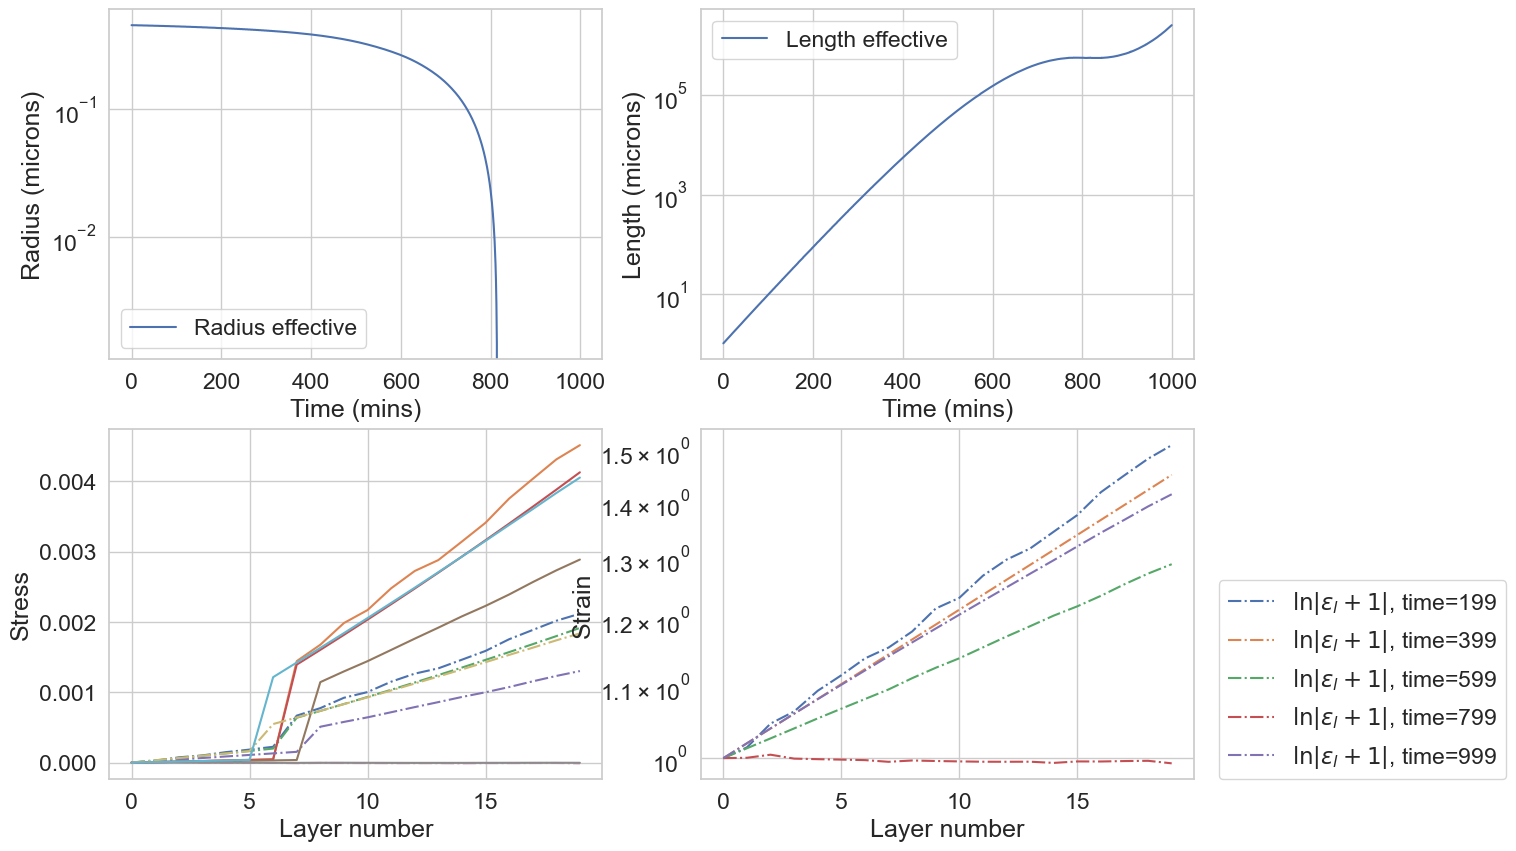

Growth rate (per min) = 0.02273
Doubling time  (mins) = 30.4923
Average cell radius = 0.44652
Theory growth rate and radius = [0.02238154 0.449365  ]


<Figure size 640x480 with 0 Axes>

In [14]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

numstep=1000
tvec=np.arange(numstep)
ri,li=sol.x[1]*np.ones(int(num_layers)),1.0*np.exp(-sol.x[0]*np.arange(0,int(num_layers)).astype(float)*params['dt'])

radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt_strain_stiffening(tvec,ri,li,params)

rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)

dr=wall_thickness/num_layers
sns.set(font_scale=1.5,style='whitegrid')
fig=plt.figure(figsize=[14,10])
plt.subplot(2,2,1)
# plt.semilogy(tvec[1:len(rad_vals)-1],rad_vals[1:len(rad_vals)-1],label='Radius')
plt.semilogy(tvec,eff_rad,label='Radius effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
plt.subplot(2,2,2)
# plt.semilogy(tvec[1:len(rad_vals)-1],l_vals[1:len(l_vals)-1],label='Length')
plt.semilogy(tvec,eff_length,label='Length effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.subplot(2,2,3)
nu=np.copy(poisson_ratio)
for ind in np.arange(len(tvec)/5-1,len(tvec),len(tvec)/5):
    ind1=ind.astype(int)
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    # Now we calculate the tensions in each layer
    alphas = alpha1 * (eps_r < strain_cutoff) + alpha2 * (
            eps_r >= strain_cutoff)  # this gives the
    # specific values for alpha for each layer in this configuration. Note that this is a vector.
    
    sig_l = dr*temp_si*((alphas/(alphas-nu**2))*eps_l+(nu/(alphas-nu**2))*eps_r) # the longitudinal tension in each layer 
    sig_r = dr*temp_si*((nu/(alphas-nu**2))*eps_l+(1/(alphas-nu**2))*eps_r) # the radial tension in each layer 
    plt.plot(sig_l,label=r'$\lambda_l/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
    plt.plot(sig_r,label=r'$\lambda_r/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Stress')

plt.subplot(2,2,4)
nu=np.copy(poisson_ratio)
for ind in np.arange(len(tvec)/5-1,len(tvec),len(tvec)/5):
    ind1=ind.astype(int)
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    plt.semilogy(eps_l+1,label=r'$\ln|\epsilon_l+1|$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
#     plt.plot(eps_r,label=r'$\epsilon_r$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Strain')
plt.legend(loc=[1.05,0.0])
plt.show()

plt.clf()

cutoff=np.nonzero(tvec>2*np.log(2)/sol.x[0])[0][0]
out=scipy.stats.linregress(tvec[:cutoff],np.log(eff_length[:cutoff]))
print("Growth rate (per min) = {0}".format(np.around(out.slope,5)))
print("Doubling time  (mins) = {0}".format(np.around(np.log(2)/out.slope,4)))
print("Average cell radius = {0}".format(np.around(np.nanmean(eff_rad[:cutoff]),5)))
print("Theory growth rate and radius =", sol.x)

Okay! So this is actually looking pretty good in terms of agreement. Let's now generate some plots for this model.

In [31]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers out you need to go in order to stiffen

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

alpha2_temp=np.linspace(0.15,0.30,4)
nus_temp = np.linspace(0.01,0.25,25)

sim_gr=np.zeros([len(alpha2_temp),len(nus_temp)])
sim_rad=sim_gr.copy()
sim_num_layers=sim_gr.copy()
mod_gr=sim_gr.copy()
mod_rad=sim_gr.copy()
mod_num_layers=sim_gr.copy()
for ind1 in range(len(alpha2_temp)):
    params['alpha2']=alpha2_temp[ind1].copy()
    for ind2 in range(len(nus_temp)):
        params['nu']=nus_temp[ind2].copy()
        if ind2==0:
            init=[0.01, 0.1]
        else:
            init=sol.x
        sol = optimize.root(min_eq_v2, init, args=(params),method='hybr')
        if sol.success: # if we converged
            mod_rad[ind1,ind2]=sol.x[1]
            mod_gr[ind1,ind2]=sol.x[0]
            mod_num_layers[ind1,ind2]=np.ceil(sol.x[1]*params['strain_cutoff']/params['dr'])
            # Now we do the simulations, seeding based on the growth rate and radii given.
            numstep=1000
            tvec=np.arange(numstep)
            ri,li=sol.x[1]*np.ones(int(num_layers)),1.0*np.exp(-sol.x[0]*np.arange(0,int(num_layers)).astype(float)*params['dt'])

            radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt_strain_stiffening(tvec,ri,li,params)
            # Now we fit these data, but we do it in a smart way, since we expect based on the simulations that
            cutoff=np.nonzero(tvec>2*np.log(2)/sol.x[0])[0][0]
#             print(ind1, ind2, cutoff,np.log(2)/sol.x[0])
            out=scipy.stats.linregress(tvec[:cutoff],np.log(eff_length[:cutoff]))
            sim_gr[ind1,ind2]=out.slope
            sim_rad[ind1,ind2]=np.nanmean(eff_rad[:cutoff])
            temp_num_layers=np.asarray([np.nonzero(((rads+params['dr'] * np.arange(0, len(rads)).astype(
        float) - rads[0]) / rads[0])>params['strain_cutoff'])[0][0] for rads in radii[:cutoff]])
            sim_num_layers[ind1,ind2]=np.nanmean(temp_num_layers)
        else:
            mod_rad[ind1,ind2]=np.nan
            mod_gr[ind1,ind2]=np.nan
            mod_num_layers[ind1,ind2]=np.nan
            sim_gr[ind1,ind2]=np.nan
            sim_rad[ind1,ind2]=np.nan
            sim_num_layers[ind1,ind2]=np.nan

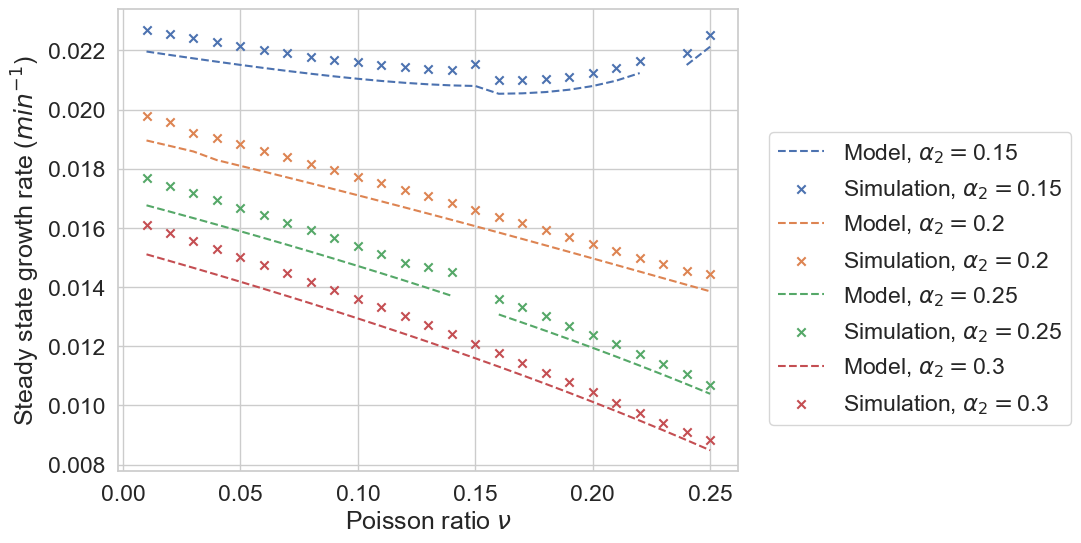

<Figure size 640x480 with 0 Axes>

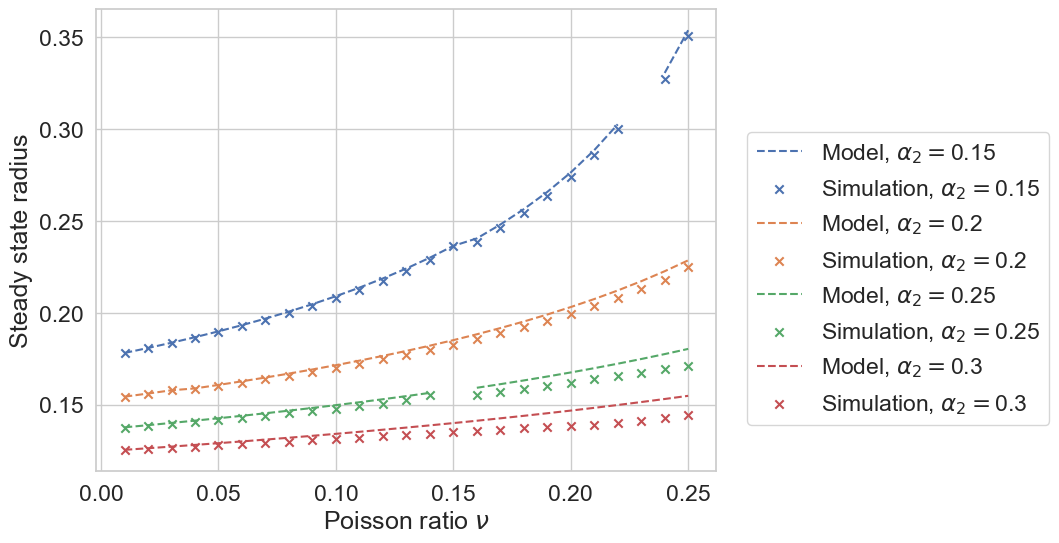

<Figure size 640x480 with 0 Axes>

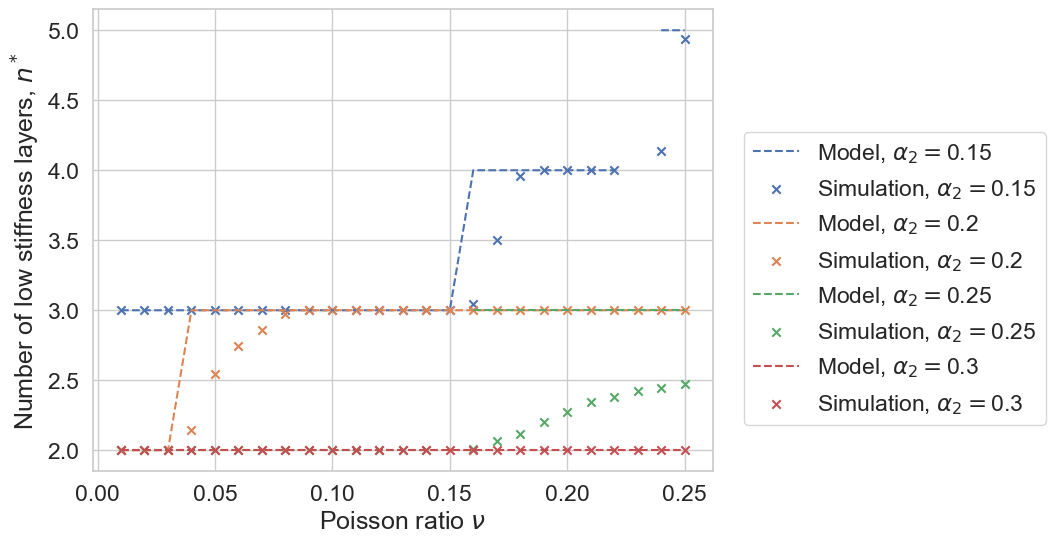

<Figure size 640x480 with 0 Axes>

In [33]:
fig=plt.figure(figsize=[8,6])
for ind in range(len(alpha2_temp)):
    temp_color=sns.color_palette()[np.mod(ind,len(sns.color_palette()))]
    plt.plot(nus_temp,mod_gr[ind,:],label=r'Model, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,linestyle='--')
    plt.scatter(nus_temp,sim_gr[ind,:],label=r'Simulation, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,marker='x')
plt.legend(loc=[1.05,0.1])
plt.ylabel('Steady state growth rate ($min^{-1}$)')
plt.xlabel(r'Poisson ratio $\nu$')
fig.savefig('./quality_figs/strain_stiffening_model_simulations_comp_gr.png',dpi=300,bbox_inches='tight')
plt.show()
plt.clf()

fig=plt.figure(figsize=[8,6])
for ind in range(len(alpha2_temp)):
    temp_color=sns.color_palette()[np.mod(ind,len(sns.color_palette()))]
    plt.plot(nus_temp,mod_rad[ind,:],label=r'Model, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,linestyle='--')
    plt.scatter(nus_temp,sim_rad[ind,:],label=r'Simulation, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,marker='x')
plt.legend(loc=[1.05,0.1])
plt.ylabel('Steady state radius')
plt.xlabel(r'Poisson ratio $\nu$')
fig.savefig('./quality_figs/strain_stiffening_model_simulations_comp_rad.png',dpi=300,bbox_inches='tight')
plt.show()
plt.clf()

fig=plt.figure(figsize=[8,6])
for ind in range(len(alpha2_temp)):
    temp_color=sns.color_palette()[np.mod(ind,len(sns.color_palette()))]
    plt.plot(nus_temp,mod_num_layers[ind,:],label=r'Model, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,linestyle='--')
    plt.scatter(nus_temp,sim_num_layers[ind,:],label=r'Simulation, $\alpha_2=${0}'.format(np.around(alpha2_temp[ind],2)),color=temp_color,marker='x')
plt.legend(loc=[1.05,0.1])
plt.ylabel('Number of low stiffness layers, $n^*$')
plt.xlabel(r'Poisson ratio $\nu$')
fig.savefig('./quality_figs/strain_stiffening_model_simulations_comp_num_layers.png',dpi=300,bbox_inches='tight')
plt.show()
plt.clf()

Great! This agreement looks very good, so now we're good to go ahead with the model predictions for growth rate and cell radius.

In [15]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers out you need to go in order to stiffen

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

nus=np.linspace(0.005,0.5,101)
alphas=np.linspace(0.005,0.5,101)
sol_rad=np.zeros([len(alphas),len(nus)])
sol_gr=np.zeros([len(alphas),len(nus)])

for ind1 in range(len(alphas)):
    temp_alpha2=alphas[ind1].copy()
    params['alpha2']=temp_alpha2
    for ind2 in range(len(nus)):
        temp_nu1 = nus[ind2].copy()
        params['nu']=temp_nu1
        if ind2==0 or sol.x[0]<0 or sol.x[1]<0 or sol.success==False:
            init = [0.002,0.2]
        else:
            init = sol.x
        sol = optimize.root(min_eq_v2, init, args=(params),method='hybr')
        if sol.success: # if we converged
            sol_rad[ind1,ind2]=sol.x[1]
            sol_gr[ind1,ind2]=sol.x[0]
        else:
            sol_rad[ind1,ind2]=-0.05
            sol_gr[ind1,ind2]=-0.05

In [16]:
def constraint_plot(temp_nu,temp_xi):
    return (1+(temp_xi-2)*temp_nu)/(2*temp_xi)

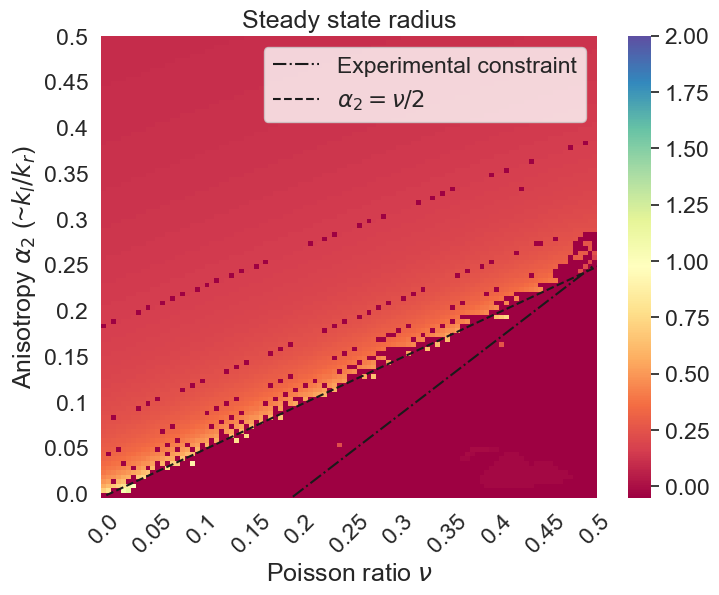

<Figure size 640x480 with 0 Axes>

In [17]:
temp_y=alphas[::-1].copy()
temp_x=nus.copy()

fig=plt.figure(figsize=[8,6])
ax=plt.subplot(1,1,1)

yticks = temp_y
keptticks = np.around(yticks[::int(len(yticks)/10)],2)
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = temp_x
keptticks = np.around(xticks[::int(len(xticks)/10)],2)
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
sns.set_style('whitegrid')
sns.heatmap(sol_rad[::-1,:],xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmax=2)
ax=plt.gca()

rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k',linestyle='-.')


temp_xv=np.arange(1,len(nus)+1)
yv=0.5*temp_x
temp_yv=len(alphas)*(1-yv/np.amax(alphas))
plt.plot(temp_xv,temp_yv,label=r'$\alpha_2=\nu/2$',color='k',linestyle='--')
plt.legend()
plt.xticks(rotation = 45)
plt.yticks(rotation = .001)
plt.xlabel(r'Poisson ratio $\nu$')
plt.ylabel(r'Anisotropy $\alpha_2$ (~$ k_l/k_r$)')
plt.title('Steady state radius')
plt.show()
fig.savefig('./quality_figs/strain_stiffening_steady_state_radius_model.png',dpi=300,bbox_inches='tight')
plt.clf()

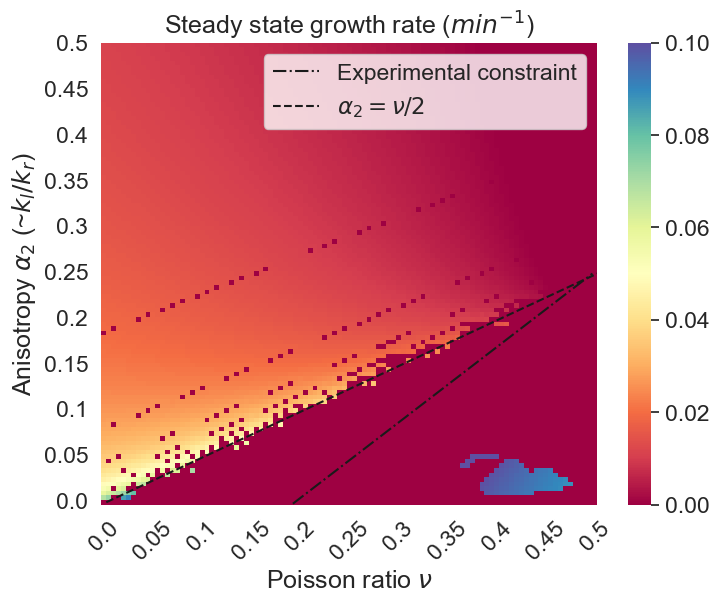

<Figure size 640x480 with 0 Axes>

In [18]:
temp_y=alphas[::-1].copy()
temp_x=nus.copy()

yticks = temp_y
keptticks = np.around(yticks[::int(len(yticks)/10)],2)
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = temp_x
keptticks = np.around(xticks[::int(len(xticks)/10)],2)
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
fig=plt.figure(figsize=[8,6])
ax=plt.subplot(1,1,1)
sns.heatmap(sol_gr[::-1,:],xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmin=0.0,vmax=0.1)
# sns.heatmap(sol_gr[::-1,:],xticklabels=xticks,yticklabels=yticks,cmap='Spectral',vmax=0.1)

rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k',linestyle='-.')

yv=0.5*temp_x
temp_xv=np.arange(1,len(nus)+1)
temp_yv=len(alphas)*(1-yv/np.amax(alphas))
plt.plot(temp_xv,temp_yv,label=r'$\alpha_2=\nu/2$',color='k',linestyle='--')
rat

ax=plt.gca()
plt.xticks(rotation = 45)
plt.yticks(rotation = .001)
plt.xlabel(r'Poisson ratio $\nu$')
plt.ylabel(r'Anisotropy $\alpha_2$ (~$ k_l/k_r$)')
plt.title('Steady state growth rate ($min^{-1}$)')
plt.legend()

plt.show()
fig.savefig('./quality_figs/strain_stiffening_steady_state_gr_model.png',dpi=300,bbox_inches='tight')
# fig.savefig('./quality_figs/steady_state_gr_model_unfiltered.png',dpi=300,bbox_inches='tight')
plt.clf()